In [1]:
# Import dependencies
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sqlite3

from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine

# Setting engine for SQLite connection
engine = create_engine("sqlite:///birthdata.sqlite", echo=False)


## Starting SQLite Connection

In [3]:
# Checking classes were made successfully: https://stackoverflow.com/questions/42946174/sqlalchemy-automap-not-generating-base-classes-table-name
engine = create_engine("sqlite:///birthdata.sqlite", echo=False)

# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

# Print all of the classes mapped to the Base
Base.classes.keys()


['clinic2010_county',
 'clinic2010_state',
 'clinic2015_county',
 'clinic2015_state',
 'county',
 'national',
 'outcomes']

In [4]:
# Create a session
session = Session(engine)

### Naming Classes

In [5]:
# Assign the classes to variables
County2015 = Base.classes.clinic2015_county
State2015 = Base.classes.clinic2015_state
County2010 = Base.classes.clinic2010_county
State2010 = Base.classes.clinic2010_state
Outcomes = Base.classes.outcomes
County_birth = Base.classes.county
National_birth = Base.classes.national


## Multi-Table Approach

### Getting Query Results from Several Tables

In [125]:
# This cell can be used if you want to compare data from different tables.
# 1) Identify tables before the period and consider what is the most logical way to merge them.
# 2) Pull in the columns of interest from each table 
# 3) Write out their join, keeping in mind 1 to 1, many to 1, etc. 
# 4) Update column names to match, keeping the first column as the element they were joined on. 
# 5) Update index to that joined column, renaming as needed 
# Resource: https://www.kite.com/python/answers/how-to-join-multiple-tables-together-in-sqlalchemy-in-python#:~:text=Use%20Query.,sequence%20to%20tables%20to%20join.

join_query = session.query(Outcomes.state, Outcomes.teen_preg, Outcomes.teen_preg_tt, State2015.total_titleten, State2015.fed_center, State2015.dept_clinic, State2015.hospital, 
                           State2015.pp, State2015.total_clinics, Outcomes.teen_bc_centers, Outcomes.teen_bc_tt, Outcomes.percent_met_centers, Outcomes.percent_met_tt)\
                    .join(State2015, State2015.state == Outcomes.state)
joined_df = pd.DataFrame(join_query, columns=["state", "teen_preg", "teen_preg_tt", "total_titleten", "fed_center", "dept_clinic", "hospital", "pp" , "total_clinics", "teen_bc_centers", "teen_bc_tt", "percent_met_centers","percent_met_tt"])
joined_df.set_index('state', inplace=True, )

# See code above to change data types if needed
# Drop NaN rows, which will mess with the ML
df = joined_df.dropna()
df.head(52)


,teen_preg,teen_preg_tt,total_titleten,fed_center,dept_clinic,hospital,pp,total_clinics,teen_bc_centers,teen_bc_tt,percent_met_centers,percent_met_tt
state,,,,,,,,,,,,
Alabama,5580,4680,83,106,77,1,2,187,20300,17010,28,24
Alaska,1310,390,5,100,16,0,5,157,4750,1400,54,18
Arizona,4540,1610,36,125,33,18,12,232,16500,5840,19,7
Arkansas,2920,2590,92,69,92,0,2,163,10610,9400,23,21
California,69560,38590,353,833,94,371,116,1697,252840,140280,64,36
Colorado,6530,2630,64,139,43,10,22,221,23720,9570,35,12
Connecticut,3900,1550,20,61,0,9,17,92,14160,5630,38,19
Delaware,1240,1150,38,9,22,0,3,41,4510,4180,30,28
District of Columbia,2030,1750,23,27,0,3,1,31,7370,6350,88,76


## Prepping the Model Data

In [149]:
# Close the session from before
session.close()

# Assign the data to X and y
# Note: Sklearn requires a two-dimensional array of values so we use reshape to create this

X = df["teen_preg"].values.reshape(-1, 1)
y = df["pp"].values.reshape(-1, 1)

print("Shape: ", X.shape, y.shape)

Shape:  (51, 1) (51, 1)


Text(0, 0.5, 'pp')

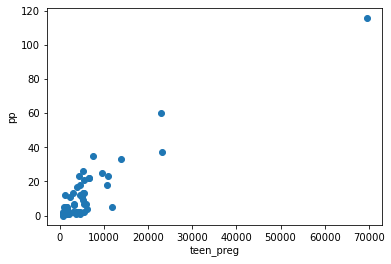

In [150]:
# Plot the data to see if a linear trend exists

### BEGIN SOLUTION
plt.scatter(X, y)
plt.xlabel("teen_preg")
plt.ylabel("pp")
### END SOLUTION

In [151]:
# Use sklearn's `train_test_split` to split the data into training and testing
# Keep in mind that our group may want to use the model on an entirely different table as well. 

from sklearn.model_selection import train_test_split # may not apply to all models

### BEGIN SOLUTION 

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### END SOLUTION

## Linear Regression

In [152]:
# Create the model

### BEGIN SOLUTION

from sklearn.linear_model import LinearRegression

model = LinearRegression()

### END SOLUTION

In [153]:
# Fit the model to the training data. 

### BEGIN SOLUTION

model.fit(X_train, y_train)

### END SOLUTION

LinearRegression()

In [154]:
# Calculate the mean_squared_error and the r-squared value
# for the testing data

from sklearn.metrics import mean_squared_error, r2_score

### BEGIN SOLUTION

# Use our model to make predictions
predicted = model.predict(X_test)

# Score the predictions with mse and r2
mse = mean_squared_error(y_test, predicted)
r2 = r2_score(y_test, predicted)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 ): {r2}")

### END SOLUTION

Mean Squared Error (MSE): 74.4405037336323
R-squared (R2 ): 0.749083626570987


In [155]:
# Call the `score` method on the model to show the r2 score

### BEGIN SOLUTION
model.score(X_test, y_test)
### END SOLUTION

0.749083626570987

## Random Forest Regressor

In [126]:
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split 


In [131]:
target = df["teen_preg"]
data = df.drop("teen_preg", axis=1)
data = data.drop("teen_preg_tt", axis=1)
feature_names = data.columns
data.head()


,total_titleten,fed_center,dept_clinic,hospital,pp,total_clinics,teen_bc_centers,teen_bc_tt,percent_met_centers,percent_met_tt
state,,,,,,,,,,
Alabama,83,106,77,1,2,187,20300,17010,28,24
Alaska,5,100,16,0,5,157,4750,1400,54,18
Arizona,36,125,33,18,12,232,16500,5840,19,7
Arkansas,92,69,92,0,2,163,10610,9400,23,21
California,353,833,94,371,116,1697,252840,140280,64,36


In [132]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)


In [133]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=20, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)


In [134]:
sorted(zip(regressor.feature_importances_, feature_names), reverse=True)

[(0.3920383166096009, 'teen_bc_centers'),
 (0.18752153872632404, 'total_clinics'),
 (0.18627094569018665, 'teen_bc_tt'),
 (0.11097684489889652, 'total_titleten'),
 (0.06905273082362237, 'fed_center'),
 (0.046513843055564844, 'hospital'),
 (0.0054436605445359046, 'pp'),
 (0.0012114920784490433, 'dept_clinic'),
 (0.0007568523539812277, 'percent_met_tt'),
 (0.00021377521883848448, 'percent_met_centers')]